In [15]:
import time
import datetime
import Hazard
from Utils.NetworkUtils import *
from Utils.Plot import *
from DynamicNetwork import DynamicNetwork
from HazardMLE import *

# Used to generate dynamic network
start_date = int(time.mktime(datetime.datetime.strptime("08/16/2016", "%m/%d/%Y").timetuple()))
file = "network_data/TheGoodPlace_sample.graphml"   # The good place network
WEEK_IN_SECOND = 7 * 24 * 60 * 60                   # Week in second
HAZARD_BETA = [0.01, 0.3, 0.3]

g = get_graphml(file)
# g = sample(g, 200/len(g))      # Get a small sample of network (200 nodes)   
graph_info(g)

Graph nodes: 2962, edges: 10595
Remove 2271 self loops.
Graph nodes: 2962, edges: 8324
Graph nodes: 200, edges: 65


In [16]:
g = DynamicNetwork(g)   
# Hazard model simulation, using params [beta1, beta2, beta3] = [0.01, 0.3 ,0.3]
model = Hazard.Hazard(g, start_date, WEEK_IN_SECOND, HAZARD_BETA)        
ref_result, fake_data = model.hazard()
print("Adopted users every week: {}, {} steps.".format(ref_result, len(ref_result)))

Adopted users every week: [99, 146, 177, 190, 194, 199, 200], 7 steps.


In [17]:
def fake_train_data(fake_data):
    from pandas import DataFrame, Series
    train_data_exog = []
    train_data_endog = []
    
    # For demo only begin
    for k, i in fake_data.items():
        train_data_exog.append([k[0], k[1]] + [1] + list(i[1:]) + [i[0]])
        train_data_endog.append(i[0])
    train_data_exog.sort(key=lambda i: (i[0], i[1]))
    train_data_exog = DataFrame(
        train_data_exog, 
        columns=["NODEID", "SECONDS", "CONSTANT", "ADOPTED_NEIGHBORS", "SENTIMENT", "ADOPTION"])
    print(train_data_exog.head())
    # For demo only end
    #
    
    train_data_exog = []
    train_data_endog = []
    for k, i in fake_data.items():
        train_data_exog.append([1] + list(i[1:]))
        train_data_endog.append(i[0])
    train_data_exog = DataFrame(train_data_exog, columns=["CONSTANT", "ADOPTED_NEIGHBORS", "SENTIMENT"])
    train_data_endog = Series(train_data_endog, name="ADOPTION")

    return train_data_exog, train_data_endog

# Get exog and endog for mle
exog, endog = fake_train_data(fake_data)

       NODEID     SECONDS  CONSTANT  ADOPTED_NEIGHBORS  SENTIMENT  ADOPTION
0   100083621  1471330800         1                  0   0.228243         1
1    10111462  1471330800         1                  0  -0.929719         0
2    10111462  1471935600         1                  0   0.533090         1
3  1035240312  1471330800         1                  0   0.058064         1
4   106030436  1471330800         1                  0  -0.244303         1


In [18]:
result = HazardModel(exog=exog, endog=endog).fit()
print("Beta values {}".format(result.params))

Optimization terminated successfully.
         Current function value: 0.678476
         Iterations: 101
         Function evaluations: 183


Beta values [ 0.0152311   0.58677477  0.32613163]


In [19]:
def print_loglikelihood(exogs, endogs, params):
    exogs = np.asarray(exogs)
    endogs = np.asarray(endogs)

    log_likelihood = 0

    for exog, endog in zip(exogs, endogs):
        if endog == 1:
            log_likelihood += stats.norm.logcdf(np.dot(exog, params)).sum()
        elif endog == 0:
            log_likelihood += stats.norm.logcdf(-1 * np.dot(exog, params)).sum()
        else:
            assert False, "Shouldn't run into this line"

    print("{}, {}".format(params, log_likelihood))
    
# params = [round(p, 3) for p in result.params] # Reset params to 3 digits after decimal
print("MLE loglikelihood")
print_loglikelihood(exog, endog, result.params)
print("Original loglikelihood")
print_loglikelihood(exog, endog, HAZARD_BETA)

MLE loglikelihood
[ 0.0152311   0.58677477  0.32613163], -267.9978775040834
Original loglikelihood
[0.01, 0.3, 0.3], -268.33159978276586


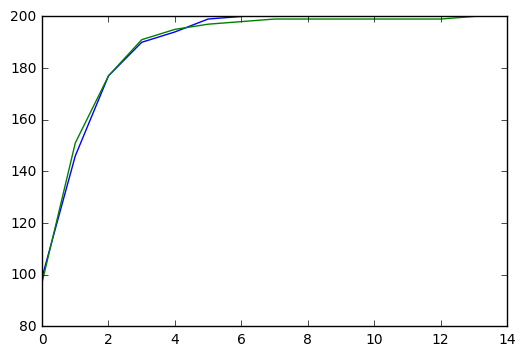

In [20]:
sim_model = Hazard.Hazard(g, start_date, WEEK_IN_SECOND, result.params)
sim_result, _ = sim_model.hazard()
plot([ref_result, sim_result])